# AxIoU: Axiomatically Justified Measure for Video Moment Retrieval
This notebook accompanies the paper "AxIoU: Axiomatically Justified Measure for Video Moment Retrieval" by Riku Togahi, Mayu Otani, Yuta Nakashima, Esa Rahtu, Janne Heikkila, Tetsuya Sakai in CVPR 2022.

This notebook show the reproducible experiments on the Charades-STA dataset.

In [1]:
cd ../

/home/riktor/vmr-axiou


In [2]:
%matplotlib inline
from skvideo.io import vread, vwrite
from typing import List
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import src
import src.toolbox.eval
from src.toolbox.eval import _tiou
from src.toolbox.data_converters import CharadesSTA2Instances

import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
sns.set_style("white")

# Data preparation
* We load the testing data and 6 systems' predictions.
* We evaluate the predictions of 6 systems (i.e. prior, 2DTAN, 2DTAN w/o NMS, SCDM, 2DTAN with video frames shuffling and 2DTAN w/ shuffling w/o NMS).

In [3]:
# load testing data
test_data = CharadesSTA2Instances(pd.read_csv("data/processed/charades/test.csv"))

In [4]:
# load the predictions of 6 systems
import pickle
results_prior = pickle.load(open('data/processed/charades/predictions_045.pkl', 'rb'))
results_2dtan = pickle.load(open('data/processed/charades/2DTAN_results_charadeSTA.pkl', 'rb'))
results_2dtan_nonms = pickle.load(open('data/processed/charades/2DTAN_results_charadeSTA_nonms.pkl', 'rb'))
results_scdm = pickle.load(open('data/processed/charades/SCDM_results_charadeSTA.pkl', 'rb'))
rand_results_2dtan = pickle.load(open('data/processed/charades/2DTAN_randomized_results_charadeSTA.pkl', 'rb'))
rand_results_2dtan_nonms = pickle.load(open('data/processed/charades/2DTAN_randomized_results_charadeSTA_nonms.pkl', 'rb'))

# Analysis on Agreement between Measures
* We evaluate 6 systems with each measure and investigate the Kendall's tau between two system rankings derived by two different measures.
* The detailed results are shown in Section 6.2.

In [5]:
# evaluate each system on the testing data with each measure

recl_results = []
for s in tqdm([results_2dtan,
               results_scdm, results_2dtan_nonms, rand_results_2dtan,
               rand_results_2dtan_nonms, results_prior]):
    res = src.toolbox.eval.recall(test_data, [list(r[:3]) for r in s])
    recl_results.append(res)

axiou_results = []
for s in tqdm([results_2dtan,
               results_scdm, results_2dtan_nonms, rand_results_2dtan,
               rand_results_2dtan_nonms, results_prior]):
    res = src.toolbox.eval.axiou(test_data, [list(r[:3]) for r in s])
    axiou_results.append(res)

100%|██████████| 6/6 [00:03<00:00,  2.00it/s]


In [6]:
recl = {}
for k in [1, 5, 10]:
    for th in [0.3, 0.5, 0.7]:
        recl[(k, th)] = np.float32([[r[-1][f'R@{k} IoU>{th}'] for r in res] for res in recl_results])        

axiou = {}
for k in [1, 5, 10]:
    axiou[k] = np.float32([[r[-1][f'AxIoU@{k}'] for r in res] for res in axiou_results])

In [7]:
names = [
    '2DTAN',
    'SCDM',
    '2DTAN_nonms',
    '2DTAN rand',
    '2DTAN rand_nonms',
    'Prior',
]

In [9]:
recl_all = []
axiou_all = []
for i, n in enumerate(names):
    _recl = []
    for k in recl:
        _recl.append(recl[k][i])
    _axiou = []
    for k in axiou:
        _axiou.append(axiou[k][i])
    recl_all.append(_recl)
    axiou_all.append(_axiou)
    
recl_all = np.array(recl_all) # shape of (#systems, #measures, #topics)
axiou_all = np.array(axiou_all)

In [21]:
scores = np.concatenate([recl_all, axiou_all], axis=1).mean(-1).T # shape of (#systems, #measures)

# compute agreement (Kendall's tau) between two system rankings
ts = np.zeros((len(scores), len(scores)))
for i in range(len(scores)):
    for j in range(len(scores)):
        ts[i, j] = stats.kendalltau(scores[i], scores[j])[0]
        ts[j, i] = stats.kendalltau(scores[i], scores[j])[0]

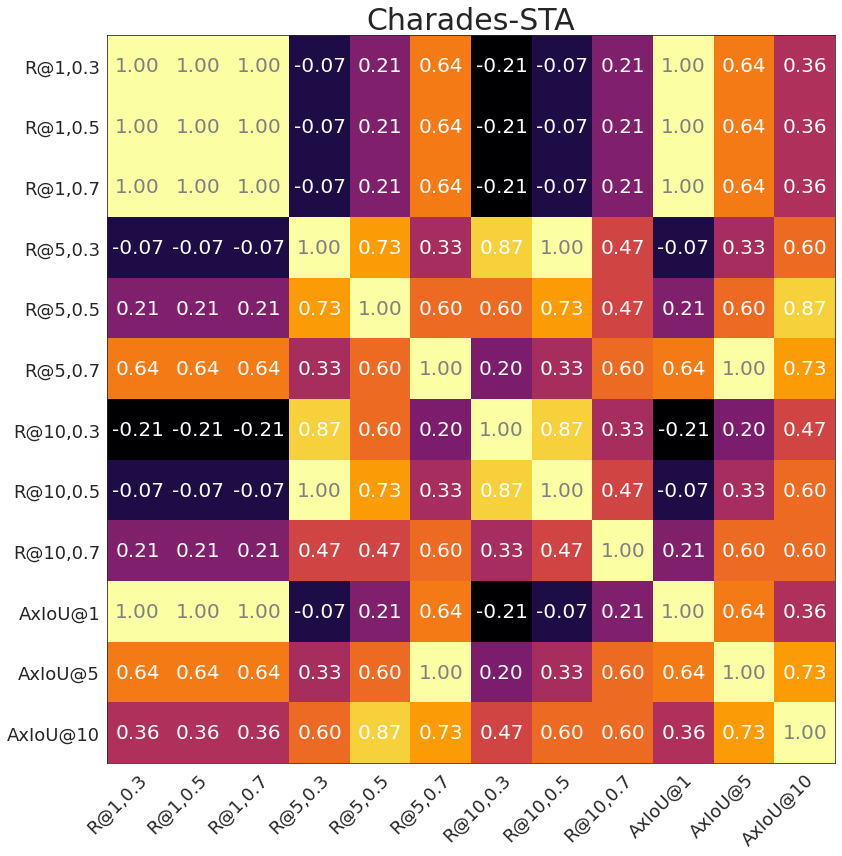

In [23]:
ks = list(recl.keys())

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(ts, cmap="inferno")

ax.set_xticks(np.arange(len(scores)))
ax.set_yticks(np.arange(len(scores)))

ax.set_xticklabels([f'R@{k[0]},{k[1]}' for k  in ks] + ['AxIoU@1', 'AxIoU@5', 'AxIoU@10'], fontsize=18)
ax.set_yticklabels([f'R@{k[0]},{k[1]}' for k  in ks] + ['AxIoU@1', 'AxIoU@5', 'AxIoU@10'], fontsize=18)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor", fontsize=18)

for i in range(len(scores)):
    for j in range(len(scores)):
        if ts[i, j] > 0.99 :
            text = ax.text(j, i, f'{ts[i, j]:.2f}',
                           ha="center", va="center", color="gray", fontsize=20)
        else:
            text = ax.text(j, i, f'{ts[i, j]:.2f}',
                           ha="center", va="center", color="w", fontsize=20)
ax.set_title("Charades-STA", fontsize=30)
fig.tight_layout()
plt.show()

# Analysis on Stability against the Choice of Evaluation Data
* We investigate the Kendall's tau between two system rankings derived by two datasets with different sizes.
* The detailed results are shown in Section 6.3.

In [24]:
def get_ts(tp):
    """
    This computes the Kendall's taus between
    the ranking based on sub-sampled dataset and that based on the entire dataset.
    """
    all_ranks, ms_list, i = tp
    np.random.seed(i)
    _ts = []
    for _ in range(len(ms_list)):
        _ts.append([])
    for j in np.arange(100, 3820, 100):
        perm = np.random.permutation(range(3720))
        for i, ms in enumerate(ms_list):
            _ts[i].append(stats.kendalltau(all_ranks[i], np.average(ms_list[i][:, perm[:int(j)]], 1))[0])
    return _ts

In [31]:
def get_self_ts(ms_list):
    """
    This evaluates the stability for 5000 sub-sampled datasets.
    """
    all_ranks = [np.average(ms, 1) for ms in ms_list]
    ts = []
    with Pool(16) as pool:
        for _ts in tqdm(pool.imap(get_ts, [(all_ranks, ms_list, i) for i in tqdm(range(5000))]), total=5000):
            ts.append(_ts) 
    return np.array(ts)

In [26]:
from multiprocessing import Pool

In [27]:
ts_list = get_self_ts([recl[k] for k in recl] + [axiou[1], axiou[5], axiou[10]])

100%|██████████| 5000/5000 [01:50<00:00, 45.37it/s]


In [29]:
axiou_10_ts = np.array([ts[-1] for ts in ts_list]).T
axiou_5_ts  = np.array([ts[-2] for ts in ts_list]).T
axiou_1_ts  = np.array([ts[-3] for ts in ts_list]).T
r10_03_ts = np.array([ts[-4] for ts in ts_list]).T 
r10_05_ts = np.array([ts[-5] for ts in ts_list]).T 
r10_07_ts = np.array([ts[-6] for ts in ts_list]).T 
r5_03_ts = np.array([ts[-7] for ts in ts_list]).T 
r5_05_ts = np.array([ts[-8] for ts in ts_list]).T 
r5_07_ts = np.array([ts[-9] for ts in ts_list]).T 
r1_03_ts = np.array([ts[-10] for ts in ts_list]).T
r1_05_ts = np.array([ts[-11] for ts in ts_list]).T
r1_07_ts = np.array([ts[-12] for ts in ts_list]).T

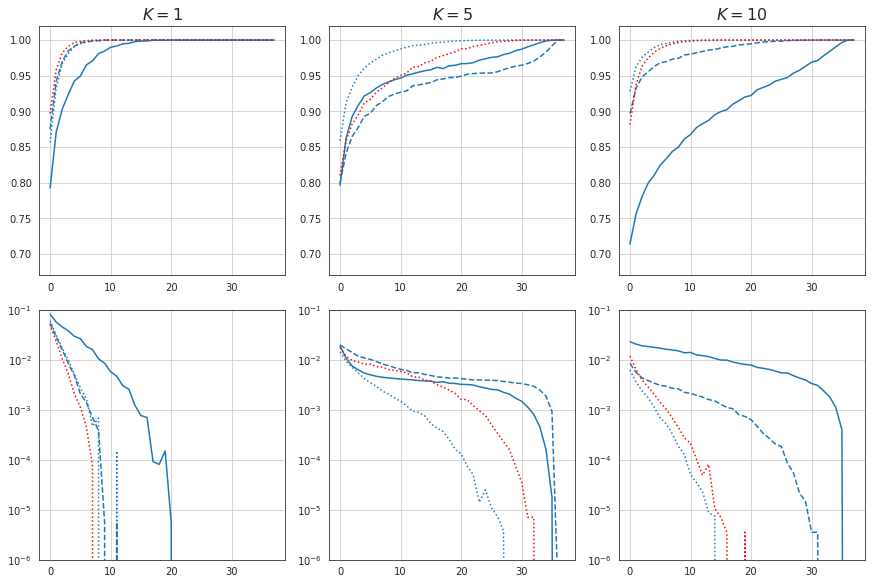

In [30]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 8),
                        constrained_layout=True)

for i, _axs in enumerate(axs):    
    for j, ax in enumerate(_axs):
        if i == 0:
            ax.set_title(f'$K={[1, 5, 10][j%3]}$', fontsize=16)
            ax.set_ylim(0.67, 1.02)
        if i == 1:
            ax.set_yscale('log')
            ax.set_ylim(1e-6, 1e-1)
        ax.grid()

labels = [f'R@{k},{theta}' for k in [1, 5, 10] for theta in [0.3, 0.5, 0.7]] + [f'AxIoU@{k}' for k in [1, 5, 10]]
lst = ['-', '--', ':'] 
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

c_ms = (r1_03_ts, r1_05_ts, r1_07_ts,
        r5_03_ts, r5_05_ts, r5_07_ts,
        r10_03_ts, r10_05_ts, r10_07_ts,
        axiou_1_ts, axiou_5_ts, axiou_10_ts,)
for i, ms in enumerate(c_ms):
    if i // 3 < 3:
        axs[0, i//3].plot(np.average(ms, 1), label=labels[i], linestyle=lst[i%3], color=cycle[0])
    else:
        axs[0, i % 3].plot(np.average(ms, 1), label=labels[i], linestyle=':', color='red')
for i, ms in enumerate(c_ms):
    if i // 3 < 3:
        axs[1, i//3].plot(np.var(ms, 1), label=labels[i], linestyle=lst[i%3], color=cycle[0])
    else:
        axs[1, i % 3].plot(np.var(ms, 1), label=labels[i], linestyle=':', color='red')

# Analysis on Stability agaist Label Ambiguity
* We investigate the RMSE between two measurements based on the datasets with different noise levels.
* The detailed results are shown in Section 6.4.

In [34]:
def generate_noisy_dataset(test_data, num_raters, rater_quality_s):
    """
    This generates a noisy dataset based on the original test_data.
    `num_raters` is the number of raters (ratings) for each topic.
    `rater_quality_s` is the noise level.
    """
    median_iou = []
    iou_vs_gt = [] 
    test_data_noise = []
    for td in test_data:
        qid, loc = td
        # original temporal region
        s, e, total = loc
        # draw `num_raters` pairs of start and end points from the noise model
        s_n = stats.norm(s, rater_quality_s).rvs(num_raters)
        e_n = stats.expon(e - s).rvs(num_raters)
        # compute inter-rater agreement by median tIoU
        mtiou = np.nanmedian([_tiou(np.array([[s_n[i], s_n[i]+e_n[i]]]), (s_n[j], s_n[j]+e_n[j]))
                              for i in range(num_raters) for j in range(i+1, num_raters)])
        median_iou.append(mtiou)
        # aggregte the drawn annotations
        s_n_agg = np.median(s_n)
        e_n_agg = np.median(e_n)
        # compute the IoU between the original and generated regions
        iou_vs_gt.append(_tiou(np.array([[s_n_agg, s_n_agg + e_n_agg]]), (s, e)))
        
        test_data_noise.append((qid, (s_n_agg, s_n_agg + e_n_agg, total)))
    return test_data_noise, median_iou, iou_vs_gt

In [35]:
test_data_noise_5_1 = generate_noisy_dataset(test_data, 5, 1.0)
test_data_noise_5_2 = generate_noisy_dataset(test_data, 5, 1.6)
test_data_noise_5_3 = generate_noisy_dataset(test_data, 5, 2.0)

In [39]:
def evaluate(test_data, results):
    recl_results = []
    axiou_results = []
    for s in results:
        res = src.toolbox.eval.recall(test_data, [list(r[:3]) for r in s])
        recl_results.append(res)
        res = src.toolbox.eval.axiou(test_data, [list(r[:3]) for r in s])
        axiou_results.append(res)
        
    recl = {}
    for k in [1, 5, 10]:
        for th in [0.3, 0.5, 0.7]:
            _recl = np.float32([[r[-1][f'R@{k} IoU>{th}'] for r in res] for res in recl_results])
            recl[(k, th)] = _recl
    axiou = {}
    for k in [1, 5, 10]:
        axiou[k] = np.float32([[r[-1][f'AxIoU@{k}'] for r in res] for res in axiou_results])
    recl_all = []
    axiou_all = []
    for i, n in enumerate(names):
        _recl = []
        for k in recl:
            _recl.append(recl[k][i])
        _axiou = []
        for k in axiou:
            _axiou.append(axiou[k][i])
        recl_all.append(_recl)
        axiou_all.append(_axiou)

    recl_all = np.array(recl_all) # shape of (#systems, #measures, #topics)
    axiou_all = np.array(axiou_all)
    return recl_all, axiou_all

In [40]:
results = [results_2dtan, results_scdm,
           results_2dtan_nonms, rand_results_2dtan,
           rand_results_2dtan_nonms, results_prior]

In [41]:
test_results = evaluate(test_data, results)

In [42]:
eval_results = []
for rating_quality in [1, 2, 3, 4]:     
    def proc(i):
        test_data_noise = generate_noisy_dataset(test_data, 5, rating_quality)
        test_results = evaluate(test_data_noise[0], results)
        return test_data_noise[1], test_data_noise[2], test_results
    
    with Pool(16) as pool:
        median_iou = []
        iou_vs_gt = []
        test_result_list = []
        for a, b, c in tqdm(pool.imap_unordered(proc, range(100))):
            median_iou.append(a)
            iou_vs_gt.append(b)
            test_result_list.append(c)
    eval_results.append((test_result_list, median_iou, iou_vs_gt))

100it [03:25,  2.06s/it]
100it [03:17,  1.98s/it]
100it [03:16,  1.96s/it]
100it [03:16,  1.96s/it]


In [55]:
mse_list_rec_list = [] 
mse_list_axi_list = [] 
for res in eval_results:
    recs = [r for r, _ in res[0]]
    axis = [a for _, a in res[0]]
    mse_vs_gt_list_rec = []
    mse_vs_gt_list_axi = []
    for k in range(9):
        mse_vs_gt_list_rec.append(
            [(np.mean(test_results[0][:, k, :], 1) - np.mean(recs[i][:, k, :], 1)) ** 2
             for i in range(100)])
    for k in range(3):
        mse_vs_gt_list_axi.append(
            [(np.mean(test_results[1][:, k], 1) - np.mean(axis[i][:, k], 1)) ** 2
             for i in range(100)])
    mse_vs_gt_list_rec = np.array(mse_vs_gt_list_rec)
    mse_vs_gt_list_axi = np.array(mse_vs_gt_list_axi)
    mse_list_axi_list.append(mse_vs_gt_list_axi)
    mse_list_rec_list.append(mse_vs_gt_list_rec)
lines = np.stack([np.sqrt(np.vstack(v)) for v in zip(mse_list_rec_list, mse_list_axi_list)])

In [56]:
lines = lines.mean(2).mean(-1)

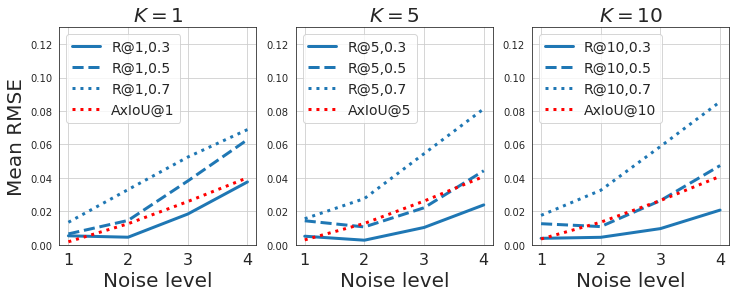

In [57]:
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(hspace=0.2)
axs = [fig.add_subplot(1, 3, c+1) for c in range(3)]

for i, ms in enumerate(lines.transpose((1, 0))):
    if i // 3 < 3:
        axs[i//3].plot(ms, label=labels[i], linestyle=lst[i%3], color=cycle[0], linewidth=3)

    else:
        axs[i%3].plot(ms, label=labels[i], linestyle=lst[-1], color='red', linewidth=3)
    
for i, ax in enumerate(axs):
    if i == 0:
        ax.set_ylabel('Mean RMSE', fontsize=20)
    ax.set_title(f'$K={[1, 5, 10][i%3]}$', fontsize=20)
    ax.set_xticks(range(4))
    ax.set_xticklabels(range(1, 5), fontsize=16)    
    ax.set_xlabel('Noise level', fontsize=20)
    if i // 3 == 0:
        ax.set_ylim(0.0, 0.13)
    else:
        ax.set_ylim(0.0, 0.05)
    ax.legend(fontsize=14, loc='upper left')
    ax.grid()

# Model Selection
* We investiage the effectiveness of each measure for model selection.
* The detailed results are shown in Section 6.6.

In [58]:
exps = ['exp-25', 'exp-26', 'exp-39',  'exp-40', 'exp-41']
base_path = 'data/validation_exp/{}/Charades/val_outputs/*.pkl'

In [65]:
import glob
from collections import defaultdict

eval_results = []
_train_data = []
for d in CharadesSTA2Instances(pd.read_csv("data/processed/charades/train.csv")):
    _train_data.append(((d[0][0], d[0][1].strip('.')), d[1]))
    
for exp in exps:
    trial = []
    paths = base_path.format(exp)
    for fn in tqdm(glob.glob(paths)):
        system = pickle.load(open(fn, 'rb'))
        recl = src.toolbox.eval.recall(_train_data, system)
        ms = defaultdict(list)
        for r in recl:
            if r[1] is not None:
                for k in [1, 5, 10]:
                    for _th in [0.3, 0.5, 0.7]:
                        ms[f'R@{k} IoU>{_th:.1f}'].append(r[3][f'R@{k} IoU>{_th:.1f}'])
        axiou = src.toolbox.eval.axiou(_train_data, system, iou_lb=0.0, top_k=[1, 5, 10, 20])
        for r in axiou:
            if r[1] is not None:
                for k in [1, 5, 10, 20]:
                    ms[f'AxIoU@{k}'].append(r[3][f'AxIoU@{k}'])
        trial.append(ms)
    eval_results.append(trial)

100%|██████████| 20/20 [01:20<00:00,  4.03s/it]


In [66]:
best_epochs = []
for res, exp in zip(eval_results, exps):
    measures_ar = []
    for ckpt in res:
        measures = np.array([np.average(ckpt[measure]) for measure in ckpt])
        measures_ar.append(measures)
    measures_ar = np.array(measures_ar)
    best_epochs.append(np.argmax(measures_ar, 0))
best_epochs = np.array(best_epochs)    

In [67]:
from src.toolbox.utils import _nms

def postproc_prediction(predictions, theta=0.5):
    preds = []
    for p in predictions:
        query = p[0]
        seg = p[1]
        keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=theta, top_k=-1)
        seg = [seg[i] for i in keep]
        preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
    return preds

In [68]:
val_base_path = 'data/validation_exp/{}/Charades/val_outputs/val_{}.pkl'
test_base_path = 'data/validation_exp/{}/Charades/test_outputs/test_{}.pkl'

In [70]:
psystems = []
for exp, epochs in tqdm(zip(exps, [set(ar) for ar in best_epochs])):
    for e in epochs:
        system = pickle.load(open(val_base_path.format(exp, e), 'rb'))
        for th in range(1, 100, 5):
            _th = th * 0.01
            psys = postproc_prediction(system, theta=_th)
            psystems.append(psys)

5it [09:51, 118.37s/it]


In [71]:
def get_val_ms(psys):
    recl = src.toolbox.eval.recall(_train_data, psys)
    ms = defaultdict(list)
    for r in recl:
        if r[1] is not None:
            for k in [1, 5, 10]:
                for _th in [0.3, 0.5, 0.7]:
                    ms[f'R@{k} IoU>{_th:.1f}'].append(r[3][f'R@{k} IoU>{_th:.1f}'])
    axiou = src.toolbox.eval.axiou(_train_data, psys, top_k=[1, 5, 10])
    for r in axiou:
        if r[1] is not None:
            for k in [1, 5, 10]:
                ms[f'AxIoU@{k}'].append(r[3][f'AxIoU@{k}'])
    ms = dict(ms)
    for measure in ms:
        ms[measure] = np.average(ms[measure])
    return ms

In [72]:
with Pool(8) as pool:
    val_ms = {}
    for ind, ms in tqdm(enumerate(pool.imap(get_val_ms, psystems))):
        val_ms[ind] = ms

640it [03:19,  3.20it/s]


In [73]:
psystems_test = []
for exp, epochs in tqdm(zip(exps, [set(ar) for ar in best_epochs])):
    for e in epochs:
        system = pickle.load(open(test_base_path.format(exp, e), 'rb'))
        for th in range(1, 100, 5):
            _th = th * 0.01
            psys = postproc_prediction(system, theta=_th)
            psystems_test.append(psys)

5it [29:51, 358.22s/it]


In [74]:
_test_data = []
for d in CharadesSTA2Instances(pd.read_csv("data/processed/charades/test.csv")):
    _test_data.append(((d[0][0], d[0][1].strip('.')), d[1]))

def get_test_ms(psys):
    recl = src.toolbox.eval.recall(_test_data, psys)
    ms = defaultdict(list)
    for r in recl:
        if r[1] is not None:
            for k in [1, 5, 10]:
                for _th in [0.3, 0.5, 0.7]:
                    ms[f'R@{k} IoU>{_th:.1f}'].append(r[3][f'R@{k} IoU>{_th:.1f}'])
    axiou = src.toolbox.eval.axiou(_test_data, psys, top_k=[1, 5, 10])
    for r in axiou:
        if r[1] is not None:
            for k in [1, 5, 10]:
                ms[f'AxIoU@{k}'].append(r[3][f'AxIoU@{k}'])
    ms = dict(ms)
    for measure in ms:
        ms[measure] = np.average(ms[measure])
    return ms

In [75]:
with Pool(8) as pool:
    test_ms = {}
    for ind, ms in tqdm(enumerate(pool.imap(get_test_ms, psystems_test))):
        test_ms[ind] = ms

640it [03:51,  2.76it/s]


In [76]:
measures_ar = []
for ind, ckpt in val_ms.items():
    measures = np.array([ckpt[measure] for measure in ckpt])
    measures_ar.append(measures)
measures_ar = np.array(measures_ar)

In [77]:
test_measures_ar = []
for ind, ckpt in test_ms.items():
    test_measures = np.array([ckpt[measure] for measure in ckpt])
    test_measures_ar.append(test_measures)
test_measures_ar = np.array(test_measures_ar)

In [78]:
_cands = np.argmax(measures_ar, 0)

In [79]:
mean_vm = measures_ar[_cands]
mean_tm = test_measures_ar[_cands]

In [80]:
show_inds = [ i for i in range(9) if i != 6]

tmr = test_measures_ar[_cands][:, show_inds]
tmr_ave = np.average(tmr, 0)
tmr_var = np.std(tmr, 0)
tmr = ((tmr - tmr_ave) / tmr_var)

In [81]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [82]:
_mnames = np.array(['R@1,0.3', 'R@1,0.5', 'R@1,0.7', 'R@5,0.3',
                    'R@5,0.5', 'R@5,0.7', 'R@10,0.3', 'R@10,0.5',
                    'R@10,0.7', 'AxIoU@1', 'AxIoU@5', 'AxIoU@10'])
_cls = [cycle[i // 3] if i < 9 else [cycle[3], cycle[4], cycle[9]][i % 3] for i in range(12)]
_lns = ['-',
        '--',
        ':',
        '-',
        '--',
        ':',
        '-',
        '--',
        ':',
        '-',
        '-',
        '-',]


In [83]:
titles = ['(a) R@$1,\\theta$', '(b) R@$5,\\theta$', '(c) R@$10,\\theta$', '(d) AxIoU@$K$']

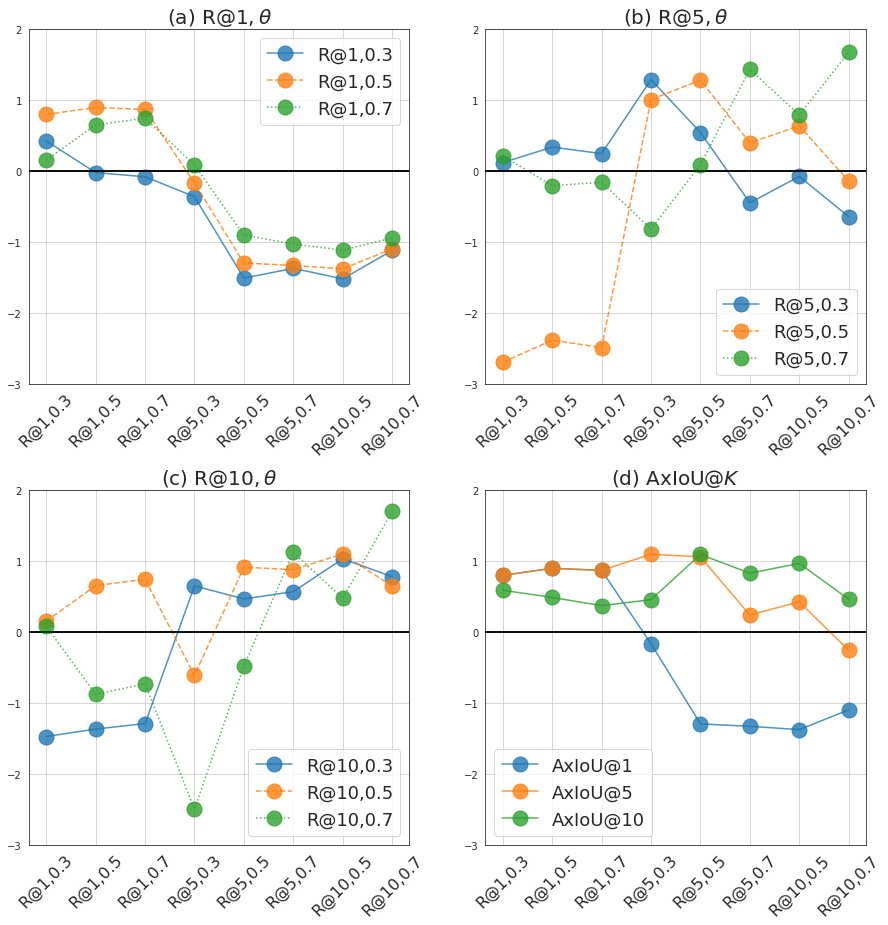

In [84]:
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.3)
axs = [fig.add_subplot(2, 2, c) for c in range(1, 5)]
for i, tm, mn, l, c in zip(range(12), tmr, _mnames, _lns, _cls):
    # print(" & ".join([f'{m:.3f}' for m in tm]))
    width = 2 if i == 11 else 1
    if np.all(tm <= 0): continue
    axs[i // 3].plot([j for j, m in enumerate(tm)],
                     [m for j, m in enumerate(tm)],
                     linestyle=l, color=cycle[i % 3], alpha=0.8, markersize=15, label=mn, marker='o')
    # axs[i // 3].scatter([j for j, m in enumerate(tm)], [m for j, m in enumerate(tm)], label=mn, marker='o', linestyle=l, color=cycle[i % 3], s=300, alpha=0.95, edgecolors='black')
    axs[i // 3].axhline(y=0.0, color='black', alpha=0.8)
    axs[i // 3].set_ylim(-3, 2.0)
    axs[i // 3].legend(loc='best', fontsize=18)
    axs[i // 3].grid()
    axs[i // 3].set_xticks(range(len(show_inds)))
    axs[i // 3].set_xticklabels(_mnames[show_inds], fontsize=16)
    axs[i // 3].set_title(titles[i // 3], fontsize=20)
    for i in axs[i // 3].get_xticklabels():
        i.set_rotation(45)